# ***Проект: Принятие решений в бизнесе***

   Проведем аналитиз данных крупного интернет-магазина. Аналитик вместе с отделом маркетинга подготовили список гипотез для увеличения выручки. Произведем приоритизацию гипотез, применив фреймворки ICE и RICE для приоритизации гипотез, запустим A/B-тест и проанализируем его результаты:
   *  оценим кумулятивную выручки по группам;
   *  кумулятивный средний чек по группам;
   *  построим график относительного изменения кумулятивного среднего чека группы B к группе A;
   *  произведем оценку аномальных значений в данных, очистим данные от них и проведем повторную оценку по выше перечисленным параметрам по "чистым" данным и сравним результаты.

 ## Подготовка данных к анализу

Для анализа представлено 3 файла с данными. Загрузим их и ознакомимся с представленной информацией.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
from scipy import stats as st
from io import BytesIO
import requests

In [2]:
def read_df(id):
    spreadsheet_id = id
    file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
    r = requests.get(file_name)
    pd.set_option('display.max_colwidth', None)
    df_name = pd.read_csv(BytesIO(r.content))
    return(df_name)

In [3]:
id = '1Dkaz2VOZ18E0v3ELPJjd2y7l4AZqcjfv1b3NfUyBuMg'
hypothesis = read_df(id)
display(hypothesis.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Структура файла:
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [4]:
id = '1spai0QK6-B04rGY3599vUcZPbTxbWMSHq7F_7AnHV1Q'
visitors = read_df(id)
display(visitors.head())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Структура файла:
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [5]:
id = '19-wRuphYg2kOGLCvZGGNHQyZ_0uCjUsycRt7b9Swamk'
orders = read_df(id)
display(orders.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Структура файла:
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Проведем предобработку данных. Для этого изучим общую информацию о содержимом датафреймов.

In [6]:
# функция для обзора данных
def df_review(df):
    display(df.head())
    print('---------------------------------------------------------------------------------------------------------')
    print(df.info())
    print('---------------------------------------------------------------------------------------------------------')
    print(df.describe())
    print('---------------------------------------------------------------------------------------------------------')
    print('Количество пропусков в значениях:',  df.isna().sum())
    print('---------------------------------------------------------------------------------------------------------')
    print('Количество дублирующих записей:', df.duplicated().sum())

In [7]:
df_review(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
---------------------------------------------------------------------------------------------------------
           Reach     Impact  Confidence    Efforts
count   9.000000   9.000000    9.000000   9.000000
mean    4.777778   4.777778    5.555556   4.888889
std     3.153481   3.192874    3.045944   2.803767
min     1.000000   1.000000    1.000000   1.000000
25%     3.000000   3.000000    3.000000   3.000000
50%     3.000000   3.000000    7.000000   

In [8]:
hypothesis.columns = [x.lower().replace(' ', '_') for x in hypothesis.columns]

In [9]:
df_review(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
---------------------------------------------------------------------------------------------------------
         visitors
count   62.000000
mean   607.290323
std    114.400560
min    361.000000
25%    534.000000
50%    624.500000
75%    710.500000
max    770.000000
---------------------------------------------------------------------------------------------------------
Количество пропусков в значениях: date        0
group       0
visitors    0
dtype: int64
------------------------------------------------------------------------------------

In [10]:
df_review(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
---------------------------------------------------------------------------------------------------------
       transactionId     visitorId       revenue
count   1.197000e+03  1.197000e+03  1.197000e+03
mean    2.155621e+09  2.165960e+09  8.348006e+03
std     1.229085e+09  1.236014e+09  3.919113e+04
min     1.062393e+06  5.114589e+06  5.000000e+01
25%     1.166776e+09  1.111826e+09  1.220000e+03
50%     2.145194e+09  2.217985e

In [11]:
#колонки с датами приведем к формату datetime
orders["date"] = orders["date"].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors["date"] = visitors["date"].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
visitors.info()
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Данные сохранены в форматах, пригодных для дальнейшего анализа.

## Часть 1. Приоритизация гипотез.

В файле hypothesis 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

1.1. Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [13]:
hypothesis['ICE'] = round((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'], 2)

display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending = False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


По методу ICE наиболее приоритетными являются гипотезы:  
  8. Запустить акцию, дающую скидку на товар в день рождения,  
  0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей,  
  7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

1.2. Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [38]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending = False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Схожая ситуация при приоритизации гипотез и с методом RICE: в приоритете гипотезы под номером  
7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок,  
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа,  
0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей,  
6. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.  
Думаю, на них стоит акцентировать свое внимание отделу маркетинга.

В пятерке лучших одни и те же гипотезы (0, 2, 6, 7, 8). Однако, если при ICE на первом месте гипотеза "Запустить акцию, дающую скидку на товар в день рождения", то при расчёте RICE, на первое место вырвалась гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".
Так получилось потому, что параметр reach Гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" равен 10, в то время как у остальных гипотез он меньше.
Параметр охвата (Reach), использующийся в методе RICE, изменил приоритетность, полученную по методу ICE.
Кроме силы гипотезы нужно учитывать и то, сколько пользователей гипотетическое изменение затронет.

## Часть 2. Анализ A/B-теста

#### 1. График кумулятивной выручки по группам.

Создадим массив уникальных пар значений дат и групп теста:

In [15]:
datesGroups = orders[['date','group']].drop_duplicates() 

Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий. 

In [16]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                                                     orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

In [17]:
visitorsAggregated = datesGroups\
.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

In [18]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulativeData.head(5))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования: 

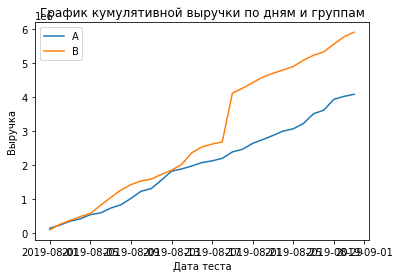

In [19]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.rcParams ['figure.figsize'] = [12, 4]
plt.legend() 
plt.title('График кумулятивной выручки по дням и группам')
plt.xlabel('Дата теста')
plt.ylabel('Выручка')
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Хороший знак.
Однако график выручки группы В в нескольких точках резко растет. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Необходимо посмотреть выбросы в данных.

#### 2. График кумулятивного среднего чека по группам. 

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

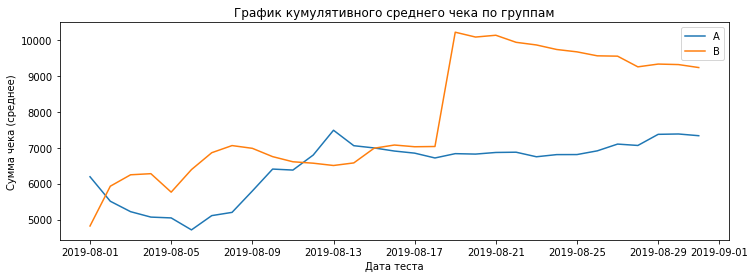

In [20]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата теста')
plt.ylabel('Сумма чека (среднее)')
plt.show()

Средний чек не становится равномерным даже к концу теста.  В целом, отношение среднего чека по группам ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Но, средний чек по группе А на протяжении почти всего теста значительно ниже, чем в группе В.
Также, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике 19.08). Следовательно, ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.


#### 3. График относительного изменения кумулятивного среднего чека группы B к группе A.

Построим график изменения кумулятивного среднего чека группы B к группе A:

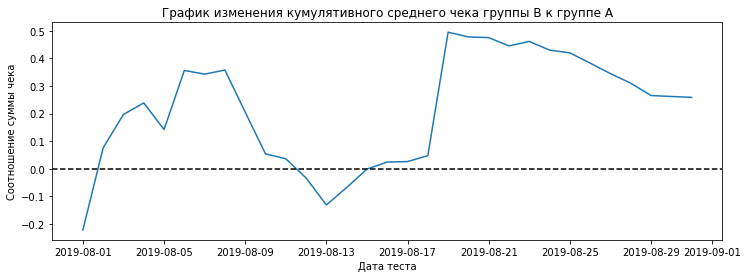

In [21]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата теста')
plt.ylabel('Соотношение суммы чека')
plt.show()


В нескольких точках график различия между сегментами резко «скачет». На такие скачки указывает наличие в данных сведений о крупных заказах и выбросах.

#### 4. График кумулятивного среднего количества заказов на посетителя по группам.

Построим график изменения кумулятивного среднего количества заказов на посетителя группы B к группе A:

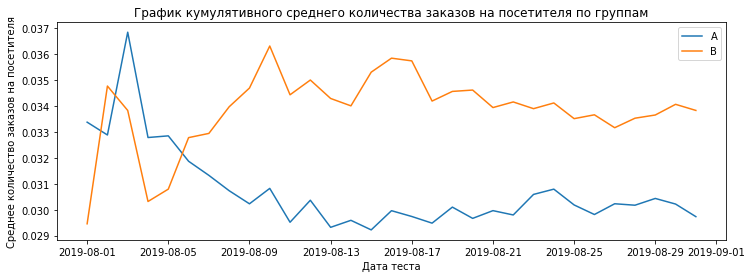

In [22]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата теста')
plt.ylabel('Среднее количество заказов на посетителя')
plt.show()


Значения в группах колебаются, но затем у группы В среднее количество заказов вырвалось вперёд, а у группы А — просело по сравнению со второй группой. Но значения не стабилизировались ни у одной из групп. Скачки наблюдаются даже в конце тестируемого периода.

#### 5. График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

Построим график изменения кумулятивного среднего количества заказов на посетителя группы B к группе A:

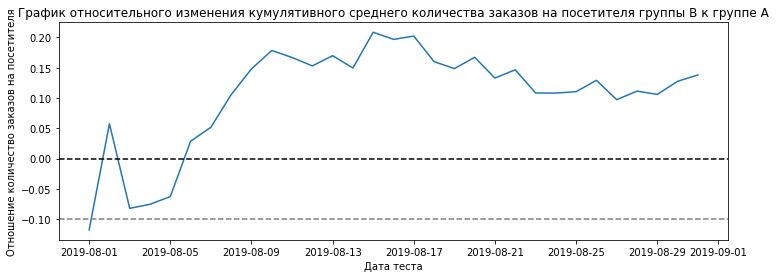

In [23]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
         mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата теста')
plt.ylabel('Отношение количество заказов на посетителя')
plt.show()

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Потом среднее количество заказов на посетителя для группы B немного уменьшалось, но все равно оставалось значительно выше значения для группы А.
В целом отношение среднего количества заказов на посетителя ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. 

#### 6.Точечный график количества заказов по пользователям.

In [24]:
ordersByUsers = (orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'}))

ordersByUsers.columns = ['visitorId', 'orders']

display(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Есть пользователи, которые совершали 5,  8 и 11 заказов. Значительно больше, чем обычный пользователь.  

Построим точечную диаграмму числа заказов на одного пользователя:

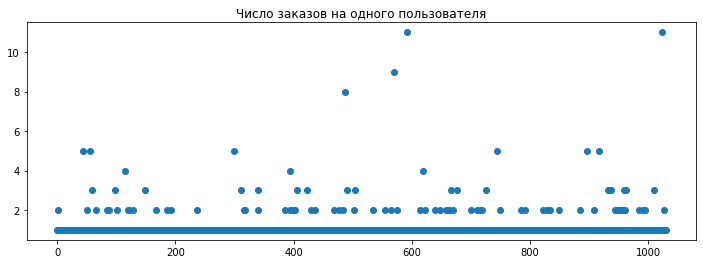

In [25]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Число заказов на одного пользователя')
plt.show()

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-4 заказами тоже значительна. Их точная доля не ясна — непонятно, считать их аномалиями или нет. 
Посчитаем выборочные перцентили количества заказов на одного пользователя:

In [26]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказf. И только 1% пользователей заказывали более 4 раз. 
Разумно выбрать 1-2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

#### 7. Точечный график стоимостей заказов по пользователям

Для выявления аномальных сумм заказов построим график и оценим стоимость заказов:

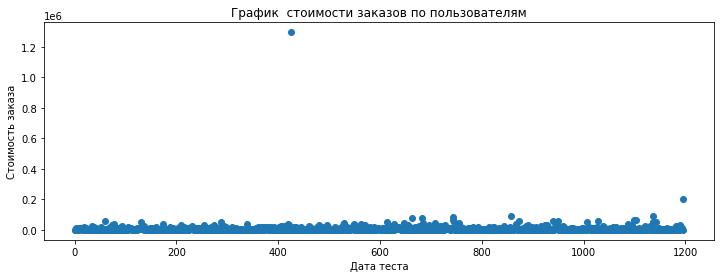

In [27]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('График  стоимости заказов по пользователям')
plt.xlabel('Дата теста')
plt.ylabel('Стоимость заказа')
plt.show()

Действительно, в данных есть заказ со стоимостью свыше 1 млн, при этом основная масса заказов кроется в границах, близких к минимуму.  
Изменим масштаб графика, чтобы лучше отобразить стоимость заказов. Ограничим стоимость в рамках 230 тыс.

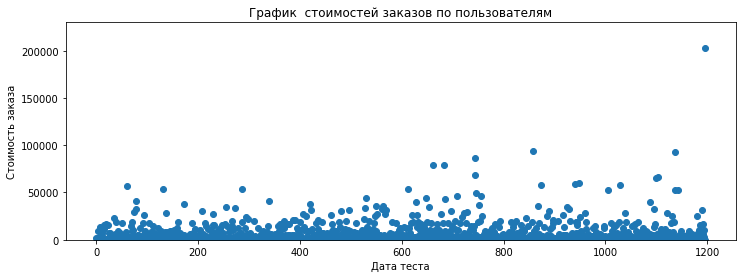

In [28]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.ylim(0, 230000)
plt.title('График  стоимостей заказов по пользователям')
plt.xlabel('Дата теста')
plt.ylabel('Стоимость заказа')
plt.show()


In [29]:
display(orders['revenue'].max())
display(orders['revenue'].mean())

1294500

8348.005847953216

На графике заметно небольшое количество заказов стоимостью свыше 50 тыс. При этом средний чек находится на уровне 8,5 тыс, а медианное значение вообще чуть больше 2,5 тыс. На такое расхождение среднего и медианного значения оказывают влияние как раз аномально дорогие заказы.

По графику можно выбрать границу аномальных заказов между 20 000 и 200 000 рублей. Однако принято отсеивать от 1% до 5% наблюдений с крайними значениями.  Чтобы определить границу аномально дорогих заказов, посчитаем перцентили. Определим 95 и 99 перцентили среднего чека в выборке:

In [30]:
display(np.percentile(orders['revenue'], [95, 99]))

array([28000. , 58233.2])

Не более 5% заказов имеют стоимость от 28 000 и выше. Следовательно, можно отбросить данные о более дорогих заказах и работать с очищенным набором для более корректного анализа.

#### 8. Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Сформулируем гипотезы:

H₀ - различий в конверсии между группами нет,  
H₁ - различия в конверсии между группами есть.  
Для расчета статистической значимости различий в конверсии между группами нам необходимо подготовить имеющиеся данные.  
Сформируем новый датафрейм data со следующими столбцами:

* date - дата;
* orders_per_date_a - количество заказов в выбранную дату в группе A;
* revenue_per_date_a - суммарная выручка в выбранную дату в группе A;
* orders_per_date_b - количество заказов в выбранную дату в группе B;
* revenue_per_date_b - суммарная выручка в выбранную дату в группе B;
* orders_cummulative_a - суммарное число заказов до выбранной даты включительно в группе A;
* revenue_cummulative_a - суммарная выручка до выбранной даты включительно в группе A;
* orders_cummulative_b - суммарное число заказов до выбранной даты включительно в группе B;
* revenue_cummulative_b - суммарная выручка до выбранной даты включительно в группе B;
* visitors_per_date_a - количество пользователей в выбранную дату в группе A;
* visitors_cummulative_a - количество пользователей до выбранной даты включительно в группе A;
* visitors_per_date_b - количество пользователей в выбранную дату в группе B;
* visitors_cummulative_b - количество пользователей до выбранной даты включительно в группе B.

In [31]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Посчитаем статистическую значимость различия в среднем количестве заказов между группами.
Создадим переменные ordersByUsersA и ordersByUsersB. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [32]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value =', "{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительное различие в средней конверсии между группами по «сырым» данным:',
      "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value = 0.01679
Относительное различие в средней конверсии между группами по «сырым» данным: 0.138


p-value = 0.01679, что меньше 0.05. Значит нулевую гипотезу об отсутствии различий по «сырым» данным в конверсии между группами можно отвергнуть. Средняя конверсия группы В больше средней конверсии группы А.

#### 9. Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Сформулируем гипотезы:  

H₀ - различий в среднем чеке между группами нет;  
H₁ - различия в среднем чеке между группами есть.

In [33]:
print('p-value =', '{0:.3f}'.format(st.mannwhitneyu(
    orders[orders['group']=='A']['revenue'],
    orders[orders['group']=='B']['revenue'])[1]))

# рассчет относительного различия в среднем чеке между группами
print('Относительное различие в среднем чеке между группами по «сырым» данным:',
      '{0:.3f}'.format(
          orders[orders['group']=='B']['revenue'].mean()/
          orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value = 0.729
Относительное различие в среднем чеке между группами по «сырым» данным: 0.259


p-value = 0.729, что больше 0,05. Нулевую гипотезу об отсутсвии различий в среднем чеке между группами отвергать нельзя. Различия есть, и они ощутимые. Средний чек группы В значительно больше среднего чека группы А.

 #### 10. Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

 95-й и 99-й перцентили средних чеков равны 28 000 и 58 233.2 рубля. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.  
 Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём от 1% до 5% пользователей с наибольшим числом заказов и 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 28 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers. 
Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [34]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head(5))
display(abnormalUsers.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitorId, dtype: int64

74

Всего 74 аномальных пользователя.   
Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. 

In [35]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Гипотезы:  

H₀ - различий в конверсии между группами нет;  
H₁ - различия в конверсии между группами есть.

In [36]:
print('p-value =', '{0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное различие в средней конверсии между группами по «очищенным» данным:', 
      '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value = 0.013
Относительное различие в средней конверсии между группами по «очищенным» данным: 0.173


p-value = 0.013, что меньше 0.05. Это означает, что нулевую гипотезу об отсутствии различий по «очищенным» данным в конверсии между группами можно отвергнуть. По «сырым» данным p-value был равен 0.0167. Средняя конверсия группы В больше средней конверсии группы А. Относительное различие в конверсии между группами по «сырым» данным было равно 0.138. Результаты по «очищенным» данным незначительно отличаются от результатов по «сырым» данным.

#### 11. Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

Сформулируем гипотезы:  

H₀ - различий в среднем чеке между группами нет;  
H₁ - различия в среднем чеке между группами есть.

In [37]:
print('p-value =', 
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное различие в среднем чеке между группами по «очищенным» данным:', 
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.738
Относительное различие в среднем чеке между группами по «очищенным» данным: -0.020


Причин отвергать нулевую гипотезу и считать, что в среднем чеке по «очищенным» данным есть различия, нет. По «сырым» данным p-value был равен 0.729. Однако, по «очищенным» данным средний чек группы А больше среднего чека группы В. По «сырым» данным было наоборот, относительное различие в среднем чеке между группами составляло 0.259.P-value увеличился, но и разница между сегментами сократилась с 25% до -2%.

### Вывод:

*Задачей исследования было:*

1. приоритизировать гипотезы,
2. запустить A/B-тест,
3. проанализировать результаты.  

*Для корретного анализа была вополнена предобработка данных:*  

* Замена названия столбцов, приведение их к нижнему регистру и правильному стилю;  
* Приведение к правильному типу данных в столбцах, содержащих информацию о дате и времени.

*В ходе приоритизации гипотез по фреймворкам ICE и RICE удалось определить наиболее важные из них:*

1. 7  Добавить форму подписки на все основные страни...  112.0
2. 2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
3. 0  Добавить два новых канала привлечения трафика,...   40.0
4. 6  Показать на главной странице баннеры с актуаль...   40.0

*Основные положения анализа результатов A/B-теста:*
  
Кумулятивный средний чек группы В выше среднего чека группы А на 25.9% к концу теста;  
Кумулятивная конверсия группы В выше конверсии группы А на 13.8% к концу теста;  
Не более 5% от всех пользователей оформляли больше чем 2 заказа, 1% пользователей оформляли заказ более 4 раз;  
Не более 5% от всех заказов имеют стоимость больше чем 28 000 рублей, 1% заказов - более 58 233 рублей;  

Статистически значимое различие по конверсии между группами присутствует как по «сырым» данным, так и по данным после фильтрации аномалий. Относительное различие в средней конверсии между группами (отношение средней конверсии группы В к средней конверсии группы А): 0.138 по «сырым» данным и 0.173 по «очищенным» данным;  

Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации.  
Относительное различие в среднем чеке между группами (отношение среднего чека группы В к среднему чеку группы А): 0.259 по «сырым» данным и -0.020 по «очищенным» данным;  

График различия конверсии между группами сообщает, что результаты группы B лучше группы A и есть тенденция к росту.  

График различия среднего чека говорит о том, что результаты группы B, несмотря на попытки роста, имеют некоторую тенденцию к снижению, сказалось, в том числе, влияние крупных заказов. По «очищенным» данным средний чек группы А оказался больше среднего чека группы В.  

Исходя из обнаруженных фактов, тест следует продолжить. Конверсия сегмента B лучше сегмента A, однако, есть основания полагать, что пристутствует тенденция к снижению среднего чека сегмента В. Показатели еще не устоялись и сильно колебаются. Необходимо некоторое время понаблюдать за этими показателями.